<a href="https://colab.research.google.com/github/Braingix/Banking-App-react-native-expo/blob/main/3D_skin_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages quietly
!pip install -q kaggle tensorflow scikit-learn pandas matplotlib seaborn h5py

# Core imports
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, auc, precision_recall_curve,
                             average_precision_score, f1_score)
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K
from google.colab import files

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [ ]:
# Upload Kaggle API token
uploaded = files.upload()

# Configure Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle competitions download -c isic-2024-challenge -p /content/

# Extract zip files
import glob
for zip_path in glob.glob("/content/*.zip"):
    !unzip -n -q "{zip_path}" -d /content/

# Define paths
train_hdf5_path = '/content/train-image.hdf5'
train_meta_path = '/content/train-metadata.csv'
test_hdf5_path = '/content/test-image.hdf5'
test_meta_path = '/content/test-metadata.csv'

Saving kaggle.json to kaggle.json
 97% 1.94G/2.00G [00:12<00:01, 39.6MB/s]
100% 2.00G/2.00G [00:12<00:00, 173MB/s] 


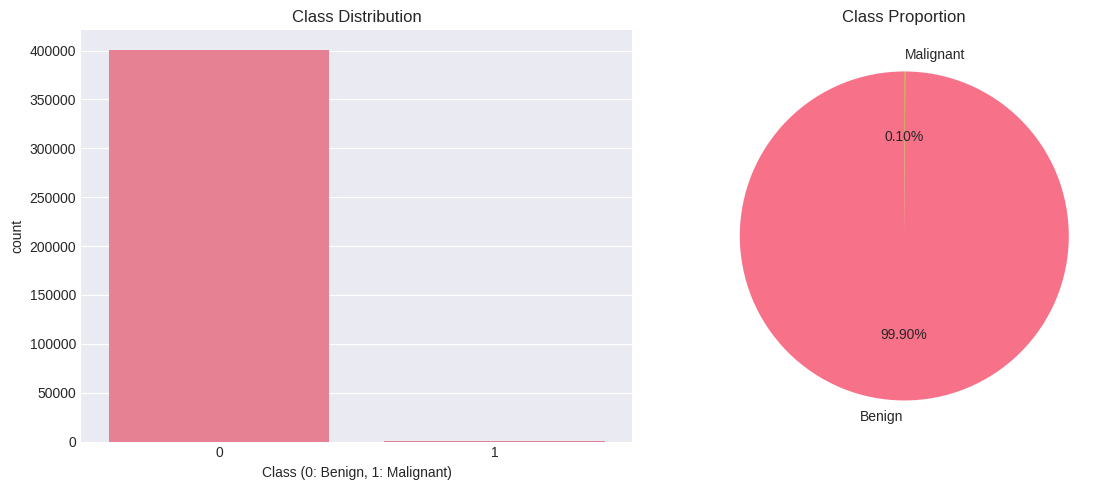

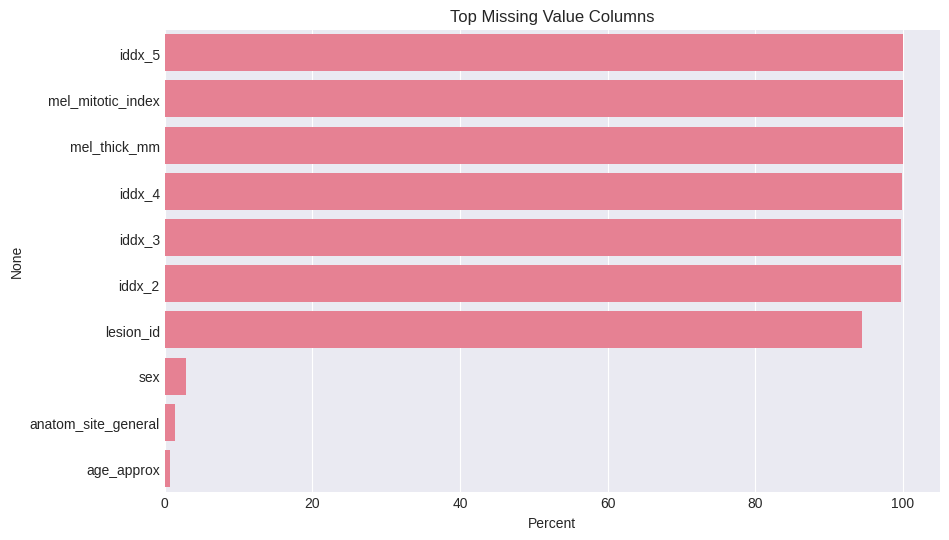

In [ ]:
# Load metadata
train_meta = pd.read_csv(train_meta_path)
test_meta = pd.read_csv(test_meta_path)

# Basic info
target_counts = train_meta['target'].value_counts()
imbalance_ratio = target_counts[0] / target_counts[1]

# Plot class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(data=train_meta, x='target', ax=ax1)
ax1.set_title('Class Distribution')
ax1.set_xlabel('Class (0: Benign, 1: Malignant)')

ax2.pie(target_counts, labels=['Benign', 'Malignant'], autopct='%1.2f%%', startangle=90)
ax2.set_title('Class Proportion')
plt.tight_layout()
plt.show()

# Missing values
missing = train_meta.isnull().sum()
if missing.sum() > 0:
    missing_pct = (missing / len(train_meta)) * 100
    missing_df = pd.DataFrame({'Missing': missing, 'Percent': missing_pct})
    missing_df = missing_df[missing_df['Missing'] > 0].sort_values('Missing', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=missing_df.head(15), x='Percent', y=missing_df.head(15).index)
    plt.title('Top Missing Value Columns')
    plt.show()

In [ ]:
# Identify column types
numeric_cols = train_meta.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_meta.select_dtypes(include=['object']).columns.tolist()

if 'target' in numeric_cols:
    numeric_cols.remove('target')

# Impute numeric columns with median
for col in numeric_cols:
    if train_meta[col].isnull().any():
        median_val = train_meta[col].median()
        train_meta[col].fillna(median_val, inplace=True)
        if col in test_meta.columns:
            test_meta[col].fillna(median_val, inplace=True)

# Impute categorical columns with mode
for col in categorical_cols:
    if train_meta[col].isnull().any():
        mode_val = train_meta[col].mode()[0] if not train_meta[col].mode().empty else 'Unknown'
        train_meta[col].fillna(mode_val, inplace=True)
        if col in test_meta.columns:
            test_meta[col].fillna(mode_val, inplace=True)

In [ ]:
# Fixed seed for reproducibility
np.random.seed(42)

# Split malignant and benign
malignant = train_meta[train_meta['target'] == 1].copy()
benign = train_meta[train_meta['target'] == 0].copy()

# Stratified validation split (20%)
val_ratio = 0.2
val_malignant = malignant.sample(frac=val_ratio, random_state=42)
train_malignant = malignant.drop(val_malignant.index)

val_benign = benign.sample(frac=val_ratio, random_state=42)
train_benign = benign.drop(val_benign.index)

# Dynamic imbalance handling: moderate undersampling to ~50:1 ratio
# This approach is optimal for extreme imbalance (~1019:1) when combined with focal loss
TARGET_RATIO = 50

n_benign_needed = len(train_malignant) * TARGET_RATIO
n_benign_available = len(train_benign)

# Use minimum to avoid oversampling or errors
n_benign_to_use = min(n_benign_needed, n_benign_available)
train_benign_sampled = train_benign.sample(n=n_benign_to_use, random_state=42)

# Combine balanced training set
train_df = pd.concat([train_benign_sampled, train_malignant])
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Full stratified validation set
val_df = pd.concat([val_benign, val_malignant])
val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Compute class weights correctly using numpy array for classes
classes = np.array([0, 1])
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_df['target'].values
)

CLASS_WEIGHTS = {0: float(class_weights_array[0]), 1: float(class_weights_array[1])}

# Add label column for data generators
train_df['label'] = train_df['target'].map({0: 'benign', 1: 'malignant'})
val_df['label'] = val_df['target'].map({0: 'benign', 1: 'malignant'})

# Save processed metadata
train_df.to_csv('/content/train_metadata_processed.csv', index=False)
val_df.to_csv('/content/val_metadata_processed.csv', index=False)

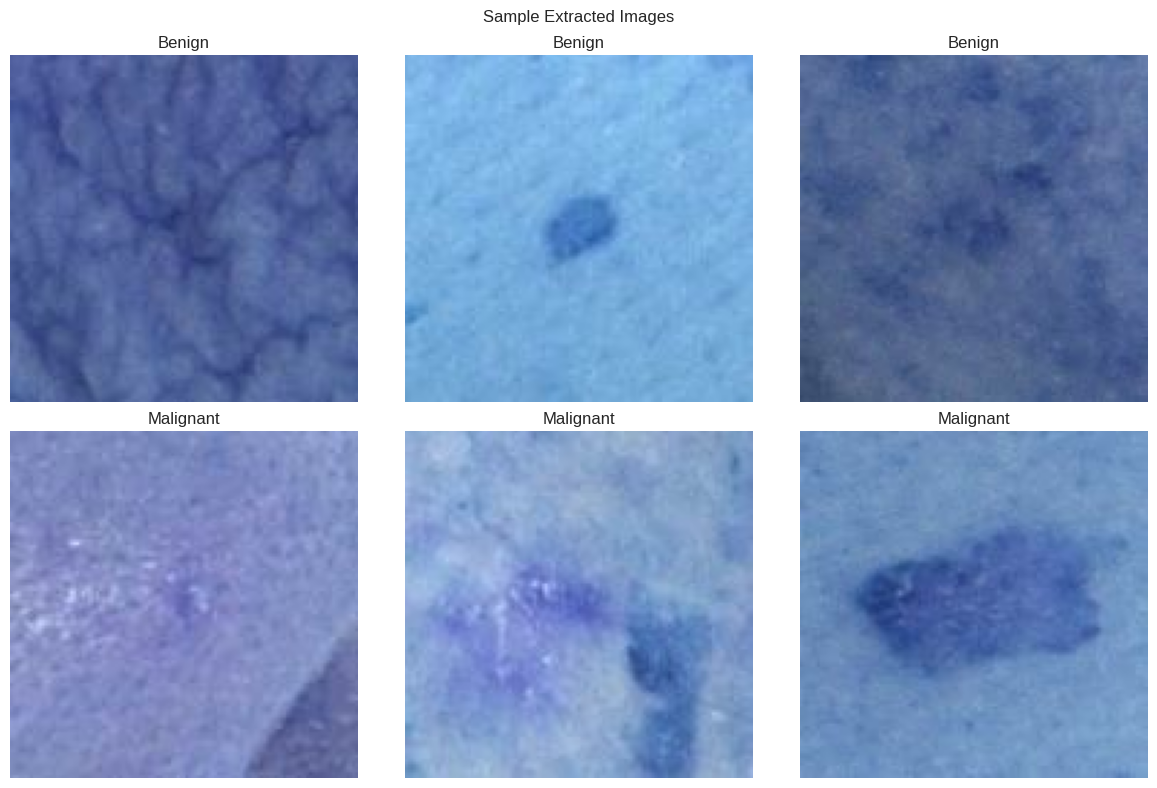

In [ ]:
import cv2
import h5py
from IPython.display import display, Image

# Create output directories
train_img_dir = '/content/train_images'
val_img_dir = '/content/val_images'
os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)

def extract_and_save(hdf5_path, df, out_dir):
    extracted = 0
    with h5py.File(hdf5_path, 'r') as hdf:
        for isic_id in df['isic_id']:
            key = str(isic_id)
            if key in hdf:
                img_bytes = hdf[key][()]
                nparr = np.frombuffer(img_bytes, np.uint8)
                img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
                if img is not None:
                    cv2.imwrite(f'{out_dir}/{isic_id}.jpg', img)
                    extracted += 1
    return extracted

# Extract images
extract_and_save(train_hdf5_path, train_df, train_img_dir)
extract_and_save(train_hdf5_path, val_df, val_img_dir)

# Display 6 sample images (3 benign, 3 malignant)
sample_benign = train_df[train_df['target'] == 0]['isic_id'].sample(3, random_state=42).tolist()
sample_malignant = train_df[train_df['target'] == 1]['isic_id'].sample(3, random_state=42).tolist()

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, isic_id in enumerate(sample_benign):
    img = plt.imread(f'{train_img_dir}/{isic_id}.jpg')
    axes[0, i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0, i].set_title('Benign')
    axes[0, i].axis('off')

for i, isic_id in enumerate(sample_malignant):
    img = plt.imread(f'{train_img_dir}/{isic_id}.jpg')
    axes[1, i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[1, i].set_title('Malignant')
    axes[1, i].axis('off')

plt.suptitle('Sample Extracted Images')
plt.tight_layout()
plt.show()

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Organize images into class folders
train_class_dir = '/content/train_organized'
val_class_dir = '/content/val_organized'

for base in [train_class_dir, val_class_dir]:
    os.makedirs(f"{base}/benign", exist_ok=True)
    os.makedirs(f"{base}/malignant", exist_ok=True)

def organize_images(df, src_dir, dst_dir):
    for _, row in df.iterrows():
        src = f"{src_dir}/{row['isic_id']}.jpg"
        dst = f"{dst_dir}/{row['label']}/{row['isic_id']}.jpg"
        if os.path.exists(src):
            os.link(src, dst)  # Hard link to save space

organize_images(train_df, train_img_dir, train_class_dir)
organize_images(val_df, val_img_dir, val_class_dir)

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_class_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

val_gen = val_datagen.flow_from_directory(
    val_class_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 16014 images belonging to 2 classes.
Found 80212 images belonging to 2 classes.


In [ ]:
import tensorflow as tf

# Use MobileNetV3Small (lighter, better for medical imaging)
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Focal loss with alpha tuned for high imbalance
def focal_loss(gamma=2.0, alpha=0.85):
    def loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        weight = alpha * y_true + (1 - alpha) * (1 - y_true)
        return -K.mean(weight * K.pow(1 - pt, gamma) * K.log(pt))
    return loss_fn

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2.0, alpha=0.85),
    metrics=['accuracy',
             tf.keras.metrics.AUC(curve='PR', name='auc_pr'),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()]
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_auc_pr', patience=8, mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_auc_pr', factor=0.5, patience=4, min_lr=1e-7),
    ModelCheckpoint('/content/best_model.keras', monitor='val_auc_pr', save_best_only=True, mode='max')
]

# Phase 1: Train top layers
history1 = model.fit(train_gen, validation_data=val_gen, epochs=25, callbacks=callbacks, class_weight=CLASS_WEIGHTS)

# Phase 2: Fine-tune
base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-5), loss=focal_loss(gamma=2.0, alpha=0.85), metrics=['accuracy', 'auc_pr', 'precision', 'recall'])

history2 = model.fit(train_gen, validation_data=val_gen, epochs=15, callbacks=callbacks, class_weight=CLASS_WEIGHTS)

Epoch 1/25
501/501 ━━━━━━━━━━━━━━━━━━━━ 344s 650ms/step - accuracy: 0.9738 - auc_pr: 0.0304 - loss: 0.0252 - precision: 0.1122 - recall: 0.0358 - val_accuracy: 0.9990 - val_auc_pr: 0.0035 - val_loss: 0.0092 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/25
501/501 ━━━━━━━━━━━━━━━━━━━━ 281s 561ms/step - accuracy: 0.9797 - auc_pr: 0.0398 - loss: 0.0200 - precision: 0.0656 - recall: 0.0048 - val_accuracy: 0.9989 - val_auc_pr: 0.0034 - val_loss: 0.0086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/25
 72/501 ━━━━━━━━━━━━━━━━━━━━ 2:49 395ms/step - accuracy: 0.9798 - auc_pr: 0.0782 - loss: 0.0158 - precision: 0.2502 - recall: 0.0806

In [ ]:
# Predictions
val_gen.reset()
y_pred_proba = model.predict(val_gen).flatten()
y_true = val_gen.classes[:len(y_pred_proba)]

# Optimal threshold via F1
thresholds = np.arange(0.1, 0.9, 0.05)
f1s = [f1_score(y_true, (y_pred_proba >= t).astype(int)) for t in thresholds]
optimal_thresh = thresholds[np.argmax(f1s)]

y_pred_opt = (y_pred_proba >= optimal_thresh).astype(int)

# Metrics
roc_auc_val = auc(*roc_curve(y_true, y_pred_proba)[:2])
pr_auc_val = average_precision_score(y_true, y_pred_proba)

cm = confusion_matrix(y_true, y_pred_opt)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Plot key curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
ax1.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_val:.4f}')
ax1.plot([0,1], [0,1], '--', color='gray')
ax1.set_title('ROC Curve')
ax1.legend()

prec, rec, _ = precision_recall_curve(y_true, y_pred_proba)
ax2.plot(rec, prec, label=f'PR AUC = {pr_auc_val:.4f}')
ax2.set_title('Precision-Recall Curve')
ax2.legend()
plt.tight_layout()
plt.show()

# Final summary
print(f"Final Model Performance (Threshold: {optimal_thresh:.2f})")
print(f"ROC-AUC: {roc_auc_val:.4f} | PR-AUC: {pr_auc_val:.4f}")
print(f"Sensitivity: {sensitivity:.4f} | Specificity: {specificity:.4f}")

In [ ]:
# Save model and metadata
model.save('/content/isic2024_final_model.keras')

# Save evaluation summary
summary = {
    'strategy': 'undersample_50to1_with_focal_loss',
    'target_ratio': TARGET_RATIO,
    'optimal_threshold': float(optimal_thresh),
    'roc_auc': float(roc_auc_val),
    'pr_auc': float(pr_auc_val),
    'sensitivity': float(sensitivity),
    'specificity': float(specificity),
    'train_samples': len(train_df),
    'val_samples': len(val_df)
}

with open('/content/model_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

# Optional download
files.download('/content/isic2024_final_model.keras')
files.download('/content/model_summary.json')